# Bank Customer Churn Modeling 

In this project, I will be analyzing customer data on a bank operating in Europe out of three countries - France, Spain and Germany. Lately, the bank has been experiencing high rates of customer churn and has been following 10,000 customers over the course of 6 months. While the bank services many more customers, the data gathered on this subset will be used to create a model to predict the likelihood of someone leaving the bank. The dataset contains geodemographic information on the customers that I will use to segment the customers and create a model. The bank can then use this model to determine which subsets of customers it should target for maximum customer retention. 

The dataset is provided in the repository. 

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.formula.api as smf
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## 1. Import Dataset

In [2]:
df = pd.read_csv('./input/Churn-Modelling.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [4]:
df.isnull().values.any()

False

Dataset contains 10,000 customers with no null values across 14 columns.

In [5]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [6]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


As we can see, our data contains financial, geographic and demographic information on the customers. `Tenure` indicates how many years the customer has been with the bank.

## 2. Exploratory Data Analysis

Since we only want to include columns that are potential features, let's remove those that provide no predictive value as well as converting qualitative features into dummy variables. 

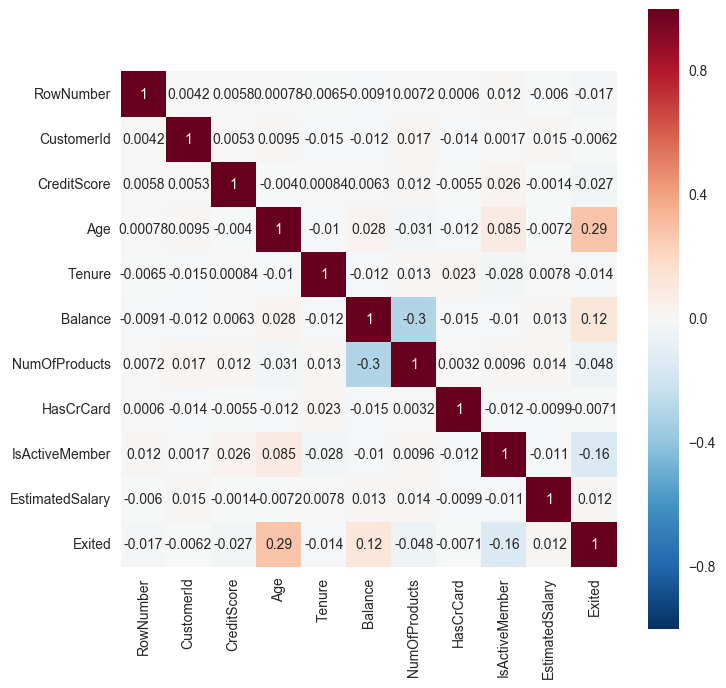

In [7]:
plt.figure(figsize=(8,8))
sns.heatmap(df.corr(),annot=True,square=True)

`Age` and `Balance` seem to have the highest correlations with exit chance while `IsActiveMember` has the lowest. 

### Ad-hoc A/B Testing

The following visualizations explore the churn rate broken down by each variable. They can be seen as ad-hoc A/B tests that show the differences in the likelihood of someone leaving based on his/her value for that variable, *ceteris paribus*. For example, the first visualization will show that customers from Germany are more likely to leave than customers in France or Spain, holding all else equal. 

Overall Percentage of Customers that exited: 20.0 %
Percentage of Customers in France that exited: 16.0 %
Percentage of Customers in Spain that exited: 17.0 %
Percentage of Customers in Germany that exited: 32.0 %


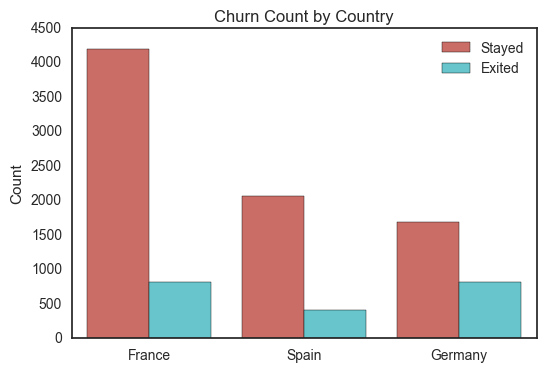

In [8]:
sns.set_style('white')

# Calculate ratio of customers per country
france_exited = df[df['Geography']=='France']['Exited'].value_counts()
spain_exited = df[df['Geography']=='Spain']['Exited'].value_counts()
germany_exited = df[df['Geography']=='Germany']['Exited'].value_counts()
overall_exited = df['Exited'].value_counts()

france_pr = france_exited[1]/(france_exited[0]+france_exited[1])*100
spain_pr = spain_exited[1]/(spain_exited[0]+spain_exited[1])*100
germany_pr = germany_exited[1]/(germany_exited[0]+germany_exited[1])*100
overall_pr = overall_exited[1]/(overall_exited[0]+overall_exited[1])*100

# Display churn count by country
sns.countplot(x='Geography',hue='Exited',data=df,palette='hls')
plt.title('Churn Count by Country')
plt.ylabel('Count')
plt.xlabel('')
plt.legend(labels=['Stayed','Exited'])

print('Overall Percentage of Customers that exited:',round(overall_pr),'%')
print('Percentage of Customers in France that exited:',round(france_pr),'%')
print('Percentage of Customers in Spain that exited:',round(spain_pr),'%')
print('Percentage of Customers in Germany that exited:',round(germany_pr),'%')

Approximately 20% (~2000) of the tracked customers ended up leaving the bank. The bank has the bulk of its customers in France where it had a churn rate of 16%. While the bank experienced below average churn rates in France and Spain, it experienced Germany experienced a churn rate of 32%, well above the 20% mark. An explanation could be a competitor springing up in Germany that is drawing customers out of our bank. The bank should bolster its marketing campaign in Germany to retain its customers there. Since Germany has such a high churn rate, there is a good chance that geographic location is a significant variable in predicting the likelihood of a customer leaving. 

Overall Percentage of Customers that exited: 20.0 %
Percentage of Non-card Holding Customers that exited: 21.0 %
Percentage of Card Holding Customers that exited: 20.0 %


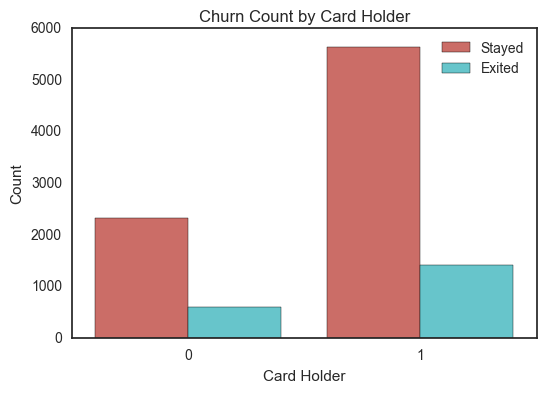

In [9]:
# Calculate ratio of customers by credit card holder
no_card_exited = df[df['HasCrCard']==0]['Exited'].value_counts()
card_exited = df[df['HasCrCard']==1]['Exited'].value_counts()

no_card_pr = no_card_exited[1]/(no_card_exited[0]+no_card_exited[1])*100
card_pr = card_exited[1]/(card_exited[0]+card_exited[1])*100

# Display churn count by credit card holder
sns.countplot(x='HasCrCard',hue='Exited',data=df,palette='hls')
plt.title('Churn Count by Card Holder')
plt.ylabel('Count')
plt.xlabel('Card Holder')
plt.legend(labels=['Stayed','Exited'])

print('Overall Percentage of Customers that exited:',round(overall_pr),'%')
print('Percentage of Non-card Holding Customers that exited:',round(no_card_pr),'%')
print('Percentage of Card Holding Customers that exited:',round(card_pr),'%')
plt.legend(labels=['Stayed','Exited'])

Although we would expect a non-card holder to have a higher chance of exiting the bank, the difference is negligible. Thus, having a card does not significantly affect a customer's chances of exiting the bank. 

Overall Percentage of Customers that exited: 20.0 %
Percentage of Female Customers that exited: 25.0 %
Percentage of Male Customers that exited: 16.0 %


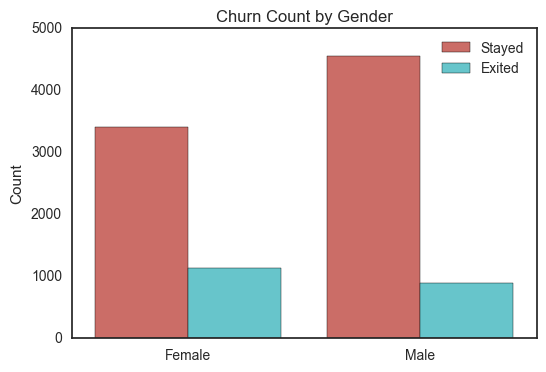

In [10]:
female_exited = df[df['Gender']=='Female']['Exited'].value_counts()
male_exited = df[df['Gender']=='Male']['Exited'].value_counts()

female_pr = female_exited[1]/(female_exited[0]+female_exited[1])*100
male_pr = male_exited[1]/(male_exited[0]+male_exited[1])*100

# Display churn count by gender
sns.countplot(x='Gender',hue='Exited',data=df,palette='hls')
plt.title('Churn Count by Gender')
plt.ylabel('Count')
plt.xlabel('')
plt.legend(labels=['Stayed','Exited'])

print('Overall Percentage of Customers that exited:',round(overall_pr),'%')
print('Percentage of Female Customers that exited:',round(female_pr),'%')
print('Percentage of Male Customers that exited:',round(male_pr),'%')

Females are more likely to leave than men (ceteris paribus) at 25%, the reason for which cannot be determined with this data - we could market more heavily towards females and see if the numbers improve. 

Overall Percentage of Customers that exited: 20.0 %
Percentage of Inactive Customers that exited: 27.0 %
Percentage of Active Customers that exited: 14.0 %


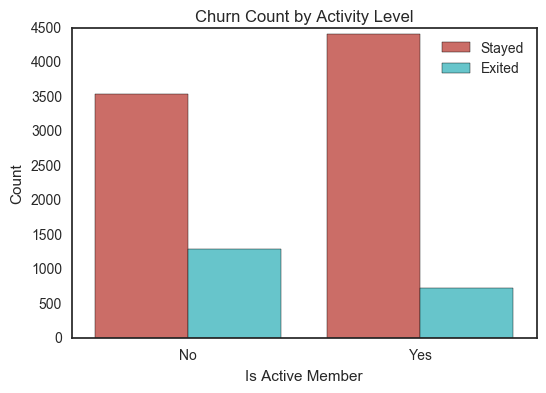

In [11]:
inactive_exited = df[df['IsActiveMember']==0]['Exited'].value_counts()
active_exited = df[df['IsActiveMember']==1]['Exited'].value_counts()

inactive_pr = inactive_exited[1]/(inactive_exited[0]+inactive_exited[1])*100
active_pr = active_exited[1]/(active_exited[0]+active_exited[1])*100

# Display churn count by activity
g = sns.countplot(x='IsActiveMember',hue='Exited',data=df,palette='hls')
g.set_title('Churn Count by Activity Level')
g.set_ylabel('Count')
g.set_xlabel('Is Active Member')
g.set(xticklabels=['No','Yes'])
plt.legend(labels=['Stayed','Exited'])

print('Overall Percentage of Customers that exited:',round(overall_pr),'%')
print('Percentage of Inactive Customers that exited:',round(inactive_pr),'%')
print('Percentage of Active Customers that exited:',round(active_pr),'%')

As expected, inactive memebers are more likely to leave than active members. The bank should periodically reach out to customers who have not been active to see if there is any additional help it can provide.  

count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: Age, dtype: float64

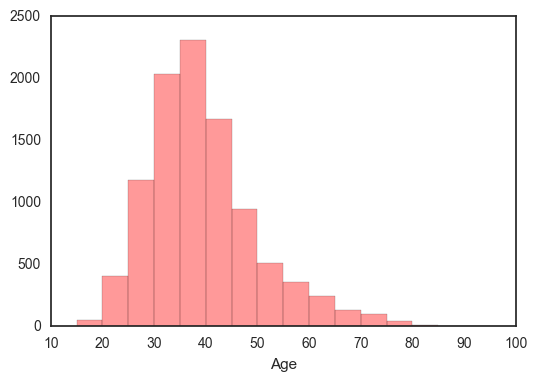

In [12]:
sns.distplot(df['Age'],color='red',bins=range(10,100,5),kde=False)
df['Age'].describe()

Most of the bank's customers are between the ages of 30 and 45. The median age is 37.

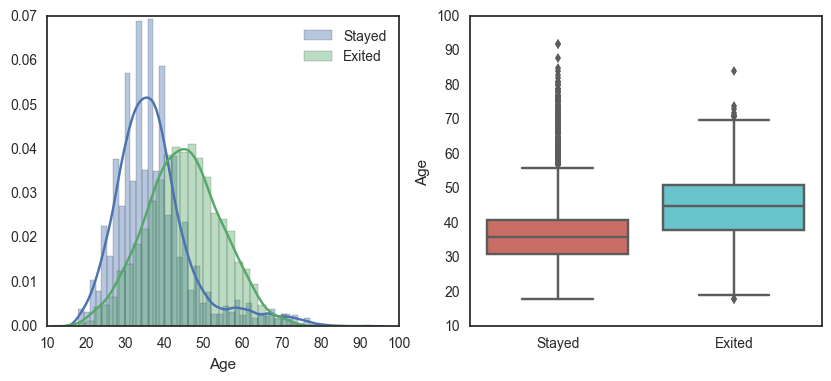

In [13]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

sns.distplot(df[df['Exited']==0]['Age'], label='Stayed', ax=ax1)
sns.distplot(df[df['Exited']==1]['Age'], label='Exited', ax=ax1)
ax1.legend()

sns.boxplot(x='Exited',y='Age',data=df,palette='hls',ax=ax2)
ax2.set_xticklabels(['Stayed','Exited'])
ax2.set_xlabel('')

These plots show that the customers who ended up leaving the bank were of an older group with the median age being about 45. The median age of those who stayed is around 35. So this tells us that an older person is more likely to leave than a younger person, all else held equal. 

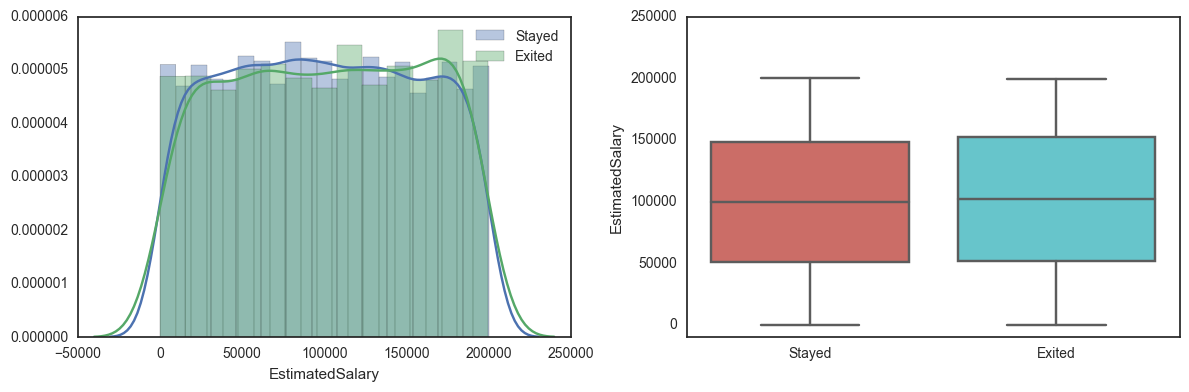

In [14]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

sns.distplot(df[df['Exited']==0]['EstimatedSalary'], label='Stayed', ax=ax1)
sns.distplot(df[df['Exited']==1]['EstimatedSalary'], label='Exited', ax=ax1)
ax1.legend()

sns.boxplot(x='Exited',y='EstimatedSalary',data=df,palette='hls',ax=ax2)
ax2.set_xticklabels(['Stayed','Exited'])
ax2.set_xlabel('')
ax2.set_ylim(-10000,250000)
plt.tight_layout()

One's estimated salary does not have a significant effect on exit chance. 

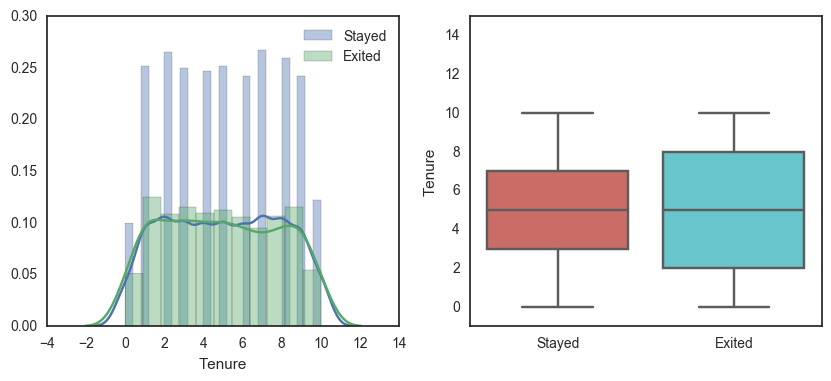

In [15]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

sns.distplot(df[df['Exited']==0]['Tenure'], label='Stayed', ax=ax1)
sns.distplot(df[df['Exited']==1]['Tenure'], label='Exited', ax=ax1)
ax1.legend()

sns.boxplot(x='Exited',y='Tenure',data=df,palette='hls',ax=ax2)
ax2.set_xticklabels(['Stayed','Exited'])
ax2.set_ylim(-1,15)
ax2.set_xlabel('')

This is perhaps the most surprising finding from our exploratory data analysis. These plots show that a customer's tenure has almost no bearing on their likelihood of exiting the bank. One would expect someone who has been with the bank for a longer period of time to have a lower chance of exiting, but we can see that the chances are pretty much the same. Therefore, tenure is not a significant variable in predicting the likelihood of someone leaving the bank. The bank should definitely take action on this discovery, perhaps by offering better incentives to loyal customers or starting a comprehensive rewards program to award those who continuously use the bank's products. 

## 3. Creating the Model

Now that we've explored each variable's effect on the likelihood on someone leaving, we're ready to create a model through logistic regression that will help us better predict a customer's chances of exiting the bank. After we transform the dataset into something we can work with (drop insignificant variables/create dummy variables), we will divide our dataset into training and testing datasets. Removing insignificant variables is akin to backwards elimination. 

In [16]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [17]:
# These columns do not offer us predictive value
df.drop(['RowNumber','CustomerId','Surname'],axis=1,inplace=True)

# Drop columns that do not have a significant effect on churn rate
df.drop(['HasCrCard','EstimatedSalary'],axis=1,inplace=True)

In [18]:
# Create dummy variables for Geography and Gender
country = pd.get_dummies(df['Geography'],drop_first=True)
gender = pd.get_dummies(df['Gender'],drop_first=True)

In [19]:
# Concatenate dummy variables to dataset
df = pd.concat([df,country,gender],axis=1)

In [20]:
# Drop columns that we used to derive dummy variable

import math
df.drop(['Geography','Gender','Spain',],axis=1,inplace=True)
df['LogBalance'] = df[df['Balance'] != 0]['Balance'].apply(lambda x: math.log(x))
df['LogBalance'].fillna(0,inplace=True)

Since the scale of `Balance` is much higher than that of the other variables, we normalize it by taking the log. 

In [21]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,IsActiveMember,Exited,Germany,Male,LogBalance
0,619,42,2,0.00,1,1,1,0.0,0.0,0.000000
1,608,41,1,83807.86,1,1,0,0.0,0.0,11.336282
2,502,42,8,159660.80,3,0,1,0.0,0.0,11.980807
3,699,39,1,0.00,2,0,0,0.0,0.0,0.000000
4,850,43,2,125510.82,1,1,0,0.0,0.0,11.740147


In [22]:
X = df.drop(['Exited','Balance'],axis=1)
y = df['Exited']

# Create training and testing datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=101)

In [23]:
from sklearn.linear_model import LogisticRegression

# Fit our model
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

# Use model to predict values in our testing dataset
predictions = logmodel.predict_proba(X_test)[:,1]
predictions_actual = [0 if x < 0.5 else 1 for x in predictions]

## 4. Assessing the Model

In [24]:
from sklearn.metrics import classification_report, confusion_matrix

In [25]:
print(classification_report(y_test,predictions_actual))
print(confusion_matrix(y_test,predictions_actual))

             precision    recall  f1-score   support

          0       0.82      0.97      0.89      1577
          1       0.65      0.19      0.29       423

avg / total       0.78      0.81      0.76      2000

[[1533   44]
 [ 343   80]]


Our model was able to accurately predict 81% of the customers' choices to stay or exit. However, only 19% of the customers that left were correctly predicted as such, so some improvements can be made on the model. Considering the large number of features included in the dataset as well as the large Type II error, I think we would get more accurate models if we had more data on customers that left since only around 2,000 of the initial set ended up leaving. 

### Odds Ratio

Now that we have our model, let's explore the odds ratio of each feature. The odds ratio tells us by how much a change in 1 unit of a feature affects (multiplicatively) our dependent variable. So, the further away the odds ratio is from 1.0, the more it affects a customer's chances of leaving the bank. 

In [26]:
odds_ratio = np.exp(logmodel.coef_)
odds_df = pd.DataFrame(odds_ratio.transpose(),X.columns,columns=['Odds Ratio'])
odds_df.sort('Odds Ratio',ascending=False)

,Odds Ratio
Germany,2.094078
Age,1.071690
LogBalance,1.030683
CreditScore,0.998931
Tenure,0.981662
NumOfProducts,0.896571
Male,0.609811
IsActiveMember,0.355708


Since the bank is looking to retain customers, it should focus on the features with the highest odds ratios. This table tells us that if a customer is located in Germany, his or her chances of leaving more than doubles (approx. 209% increase). Likewise, for every year a customer is older, his or her chances of leaving increases by about 7.2%. 

On the other hand, for every additional product a customer has with the bank, his or her chances of leaving decrease by around 10% (90% of the base chance) and being male decreases that customer's chances of leaving by 40%. Also, being an active member decreases one's chances of leaving by 65%. 

The remaining features do not have a significant effect on the chances of someone leaving as their odds ratios are close to 1.

## 5. Conclusions

* The bank should begin by targeting three groups of customers:
    1. Customers in Germany
    2. Older Customers
    3. Female Customers
* Additionally, the bank should consider beginning a loyalty program to keep tenured customers from leaving as well as offering more benefits to tenured customers.
* Finally, the bank can reach out to inactive customers and ascertain if there is anything it can provide to get them to continue using their products. 